In [3]:
#%pip install scikeras
#%pip install keras-tuner

In [35]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import savefig
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Conv1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras_tuner.tuners import RandomSearch
from collections import Counter
import pandas as pd
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import MaxPooling2D, AveragePooling2D


### Observe Data

In [8]:
fashion_set = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [9]:
(X_train, y_train), (X_test, y_test) = fashion_set

#### Xem hình ảnh thông qua pyplot

In [10]:
def plot_image(X, y, images_per_row=10, name=''):
    size = 28 #default size X_train.shape
    number_img = X.shape[0]
    X = X.reshape(number_img, size, size)
    no_rows = int(np.ceil(number_img/images_per_row))
    n_empty_image = no_rows * images_per_row - number_img

    #combine input with empty set
    image_set = np.concatenate([X, np.zeros((n_empty_image, size, size))], axis=0)
    label_set = np.concatenate([y, -np.ones(n_empty_image)], axis=0)
    #image_grid = image_set.reshape(no_rows, images_per_row, size, size)
    #images = image_grid.transpose(0,2,1,3).reshape(no_rows * size, images_per_row * size)
    print(image_set.shape)
    #plt.imshow(X=images, , cmap=mpl.cm.binary)
    fig, axes = plt.subplots(nrows=no_rows, ncols=images_per_row, figsize=(images_per_row * 1.5,no_rows))
    fig.tight_layout(pad=0.13, rect=[0, 0.12, 1, 2]) #[left,bottom, right, top]

    for (i,ax), y_set in zip(enumerate(axes.flat), label_set):
        ax.imshow(image_set[i], cmap='binary')
        ax.set_title(f'{y_set}')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(name, x=0.5, y=2.25)


(6, 28, 28)


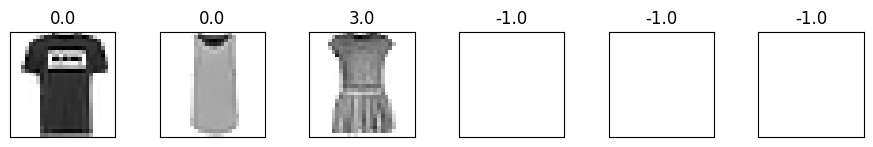

In [11]:
plot_image(X_train[1:4], y_train[1:4], images_per_row=6)

#### Thống kê data

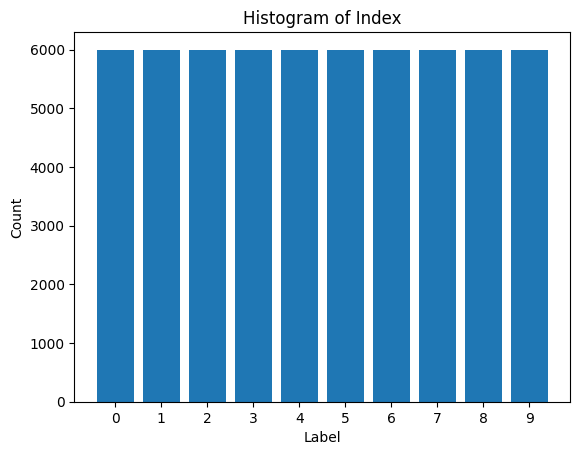

In [12]:

y_counter = Counter(y_train)
df = pd.DataFrame.from_dict(y_counter, orient='index', columns=['Count']).sort_index(ascending=True)
indexs = df.index
count_n = df['Count']
plt.bar(indexs, count_n, align='center')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Histogram of Index')
plt.xticks(indexs)
savefig('distribution of label.png')
plt.show()

Dựa vào diagram ở trên có thể thấy số lượng tập train là đồng đều không bị mất cân bằng về các label

### Preprocess Data

Để thuận tiện cho việc tính toán ta cần xử lý data. Thấy rằng giá trị của các tập X đều nằm trong khoảng từ 0 - 255, vì thế ta có thể normalize các giá trị của các tập dữ liệu để dễ dàng tính toán

In [13]:
print(f'giá trị nhỏ nhất: {np.min(X_train)}')
print(f'giá trị lớn nhất: {np.max(X_train)}')

giá trị nhỏ nhất: 0
giá trị lớn nhất: 255


Và vì dùng giải thuật CNN nên phải reshape các tập dữ liệu đầu vào, biết rằng các tập dữ liệu có shape (<b>m</b>, 28, 28) và cần đưa về shape (<b>m</b>, 28, 28, 1)

<b>m</b>: số lượng đầu vào input(ở tập X_train là 60000, ở tập X_test: 10000)

In [14]:
print(f'Shape X_train: {X_train.shape}')
print(f'Shape X_test: {X_test.shape}')

Shape X_train: (60000, 28, 28)
Shape X_test: (10000, 28, 28)


Vì cần xử lí 2 vấn đề ở trên nên tiến hành tạo 1 pipeline cho phép xử lý data:

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_process = X/255
        return X_process.reshape(X.shape[0], 28, 28, 1)

In [16]:
processor = Pipeline([
    ('Process', Preprocessor())
])

### import model

In [17]:
#Split Data from train set to train and cross set
from sklearn.model_selection import train_test_split
X_train_, X_cross_, y_train_,  y_cross = train_test_split(X_train, y_train, random_state=42, train_size=0.8, stratify=y_train)

### Implement thuần CNN

In [ ]:
#input shape(28, 28)

model = Sequential([
    Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)),
    Conv2D(16, (3,3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='linear')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))

In [18]:
X_train_process = processor.fit_transform(X_train_)
X_cross_process = processor.transform(X_cross_)

In [ ]:
print(np.max(X_cross_process[:1]))

1.0


In [ ]:
history = model.fit(X_train_process, y_train_, verbose=1, epochs=20, validation_data=(X_cross_process, y_cross))

RuntimeError: ignored

In [ ]:
from sklearn.metrics import accuracy_score
X_test_process = processor.transform(X_test)
y_pred = np.argmax(model.predict(X_test_process), axis=1)
#print(X_test_process.shape, y_pred.shape)
print(accuracy_score(y_test, y_pred))

313/313 [==============================] - 1s 2ms/step
0.9022


### Nhận xét khi Implement thuần

In [ ]:
history_frame = pd.DataFrame(history.history)

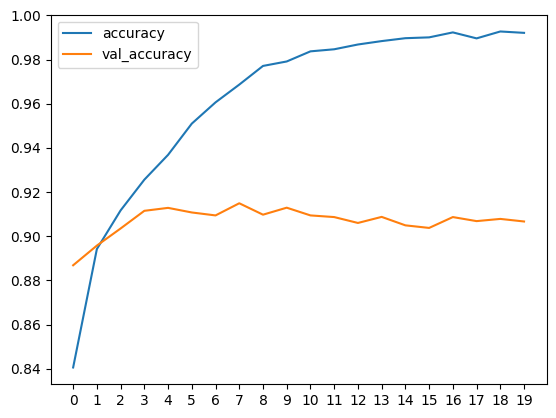

In [ ]:
history_frame[['accuracy', 'val_accuracy']].plot()
k = plt.xticks(history_frame.index)
savefig('acc_vs_cv_acc_before_tuning_model.png')

Nhận thấy có 1 khoảng cách rất lớn giữa accuracy và val_accuracy ==> High variance

In [ ]:
model.save('model_before_tuning.h5')

### Xử lý High Variance problem

### Tuning model

#### Để tiến hành giảm High Variance problem chúng ta có thể thực hiện các bước sau
- Lấy thêm nhiều dữ liệu
- Regularization
- Tìm thêm Neural Network architecture

#### Lấy thêm dữ liệu

Sử dụng phương pháp augement data để có thể tạo thêm nhiều dữ liệu cho tập train

In [23]:
from keras.preprocessing.image import ImageDataGenerator


Sinh data theo các phương pháp:
* RandomFlip
* RandomRotation
* Shifting
* Zoom

In [24]:
data_generator = ImageDataGenerator(rotation_range=10, zoom_range=0.1,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    fill_mode='nearest', cval=0)

In [25]:
data_generator.fit(X_train_process)

In [26]:
batch = data_generator.flow(X_train_process, y_train_, seed=42, batch_size=128)
batch.image_data_generator

In [27]:
X_batch, y_batch = data_generator.flow(X_train_process, y_train_, batch_size=10, shuffle=False).next()

(10, 28, 28)
(10, 28, 28)


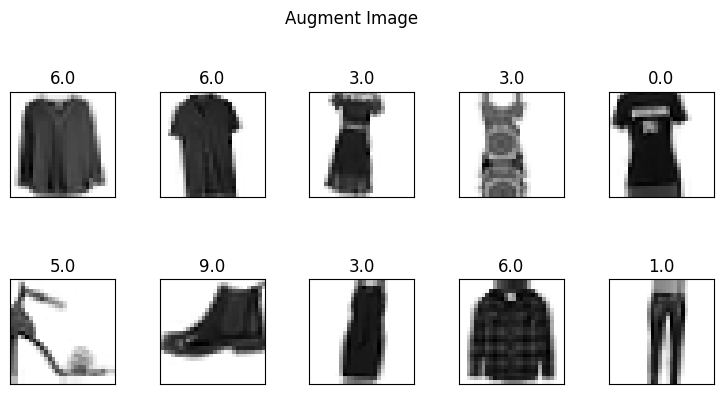

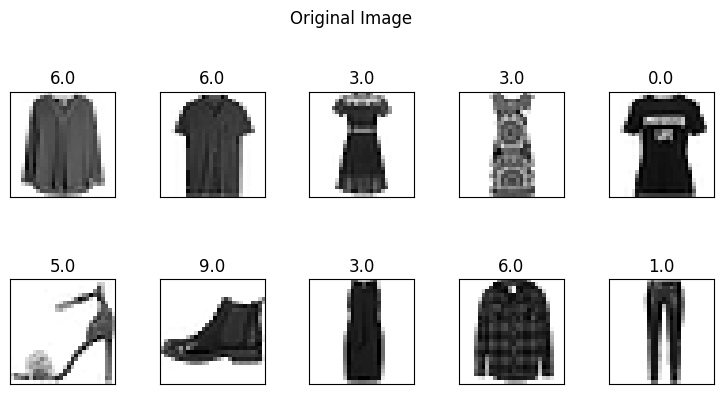

In [28]:
plot_image(X_batch[:10], y_batch[:10], 5, 'Augment Image')
plot_image(X_train_process[:10], y_batch[:10], 5, 'Original Image')

####

In [29]:
X_augment, y_augment = data_generator.flow(X_train_process, y_train_, batch_size=X_train_process.size).next()

In [30]:
X_augment_train = np.concatenate((X_augment, X_train_process), axis=0)
y_augment_train = np.concatenate((y_augment, y_train_), axis=0)
print(y_augment_train.shape)
shuffle_indices = np.random.permutation(X_augment_train.shape[0])
X_augment_train = X_augment_train[shuffle_indices]
y_augment_train = y_augment_train[shuffle_indices]

(96000,)


(10, 28, 28)


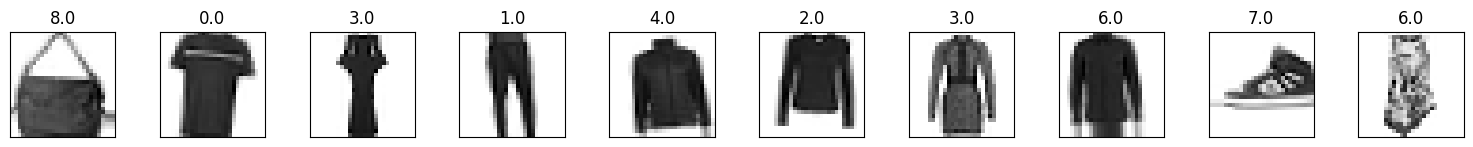

In [31]:
plot_image(X_augment_train[:10], y_augment_train[:10])

### Regularization

* Sử dụng L2Regularization (Weight decay)
* Dropout

In [ ]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience=5, restore_best_weights=True)

In [ ]:
def create_model(hp):
    model = Sequential()
    model.add(Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)))

    pool_type = hp.Choice('pool_type', ['max', 'average'])

    if pool_type=='max':
        model.add(MaxPooling2D(pool_size=(2,2)))
    elif pool_type=='average':
        model.add(AveragePooling2D(pool_size=(2,2)))

    model.add(
        Conv2D(hp.Int('conv2d_layers',32,64), (3,3), activation='relu')
    )

    model.add(Flatten())

    for i in range(hp.Int('dense_layers', 2, 3)):
      model.add(Dense(
          hp.Int(f'no_layers_{i}', min_value=32, max_value=512,step=32),
          activation=hp.Choice(f'activation_{i}', ['relu','softmax']),
          kernel_regularizer=regularizers.l2((hp.Float(f'kernel_reg_{i}', min_value=1e-3, max_value=1e-1))
      )))
      if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))

    model.add(Dense(10, activation='linear'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))
    return model

In [ ]:
model_rs = RandomSearch(create_model,
                        objective='val_accuracy',
                        max_trials=5,
                        executions_per_trial=2,
                        directory='model_random_stored',
                        project_name='model_training')


In [ ]:
model_rs.search_space_summary()

Search space summary
Default search space size: 11
pool_type (Choice)
{'default': 'max', 'conditions': [], 'values': ['max', 'average'], 'ordered': False}
conv2d_layers (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
no_layers_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'softmax'], 'ordered': False}
kernel_reg_0 (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
no_layers_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 

In [ ]:
model_rs.search(X_augment_train, y_augment_train, callbacks=[early_stop], epochs=20, validation_data=(X_cross_process, y_cross))

Trial 4 Complete [00h 11m 33s]
val_accuracy: 0.8120416700839996

Best val_accuracy So Far: 0.9005416631698608
Total elapsed time: 00h 33m 57s


In [ ]:
grid_result

RandomizedSearchCV(cv=2,
                   estimator=KerasClassifier(epochs=20, model=<function create_model at 0x7c0c5946c040>),
                   n_iter=3,
                   param_distributions={'model__dropout_rate': [0.0, 0.2, 0.3],
                                        'model__kernel_regular': [0.01, 0.1],
                                        'model__pool_type': ['max', 'average']},
                   random_state=42, verbose=1)

In [ ]:
grid_result.best_estimator_.model_.save('model_after_tuning.h5')

In [ ]:
y_pred_reg = grid_result.predict(X_test_process)
accuracy_score(y_test, y_pred_reg)
#y_pred_reg

  7/313 [..............................] - ETA: 2s 

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 2s 7ms/step


0.8831

### Transfer Learning

In [ ]:
#%pip install tensorflow_hub

In [5]:
def expand_gray_scale(X_train):
    X_train_3_channel = X_train.repeat(3, axis=-1) #expand to 3 dimension
    return X_train_3_channel

In [38]:
X_augment_train_3 = expand_gray_scale(X_augment_train)

In [39]:
X_augment_train_3.shape

(96000, 28, 28, 3)

In [36]:
transfer_model = Sequential()
transfer_model.add(ResNet50(include_top=False,pooling='avg', weights='imagenet'))

transfer_model.add(Dense(512,activation='relu'))
transfer_model.add(Dense(10, activation='linear'))


transfer_model.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=True))


94765736/94765736 [==============================] - 0s 0us/step


In [37]:
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24,641,930
Trainable params: 24,588,810
Non-trainable params: 53,120
_________________________________________________________________


In [40]:
transfer_model.fit(X_augment_train_3, y_augment_train,epochs=10)

Epoch 1/10
   4/3000 [..............................] - ETA: 2:15:19 - loss: 2.8862 - accuracy: 0.2500

KeyboardInterrupt: ignored

Preprocess Data

In [ ]:
tf.config.run_functions_eagerly(False)
#history_model = model_transfer.fit(X_augment_train_3, y_augment_train, verbose=1)